In [3]:
import math
import numpy as np 
import matplotlib.pyplot as plt 
%matplotlib inline

In [4]:
def f(x):
    return 3*x**2 - 4*x + 5

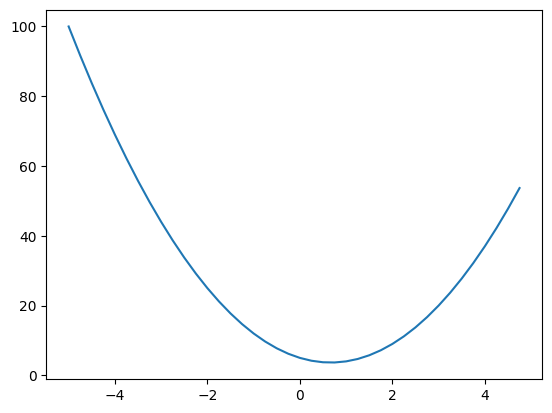

In [5]:
xs = np.arange(-5, 5, 0.25)
ys = f(xs)
plt.plot(xs, ys)

In [6]:
h = 0.00001
x = 3
(f(x+h) - f(x))/h

14.00003000000538

In [7]:
a = 2.0
b = -3.0
c = 10.0
d = a*b + c 
d

4.0

In [8]:
h = 0.0001

# inputs
a = 2.0
b = -3.0
c = 10.0

d1 = a*b + c
c += h
d2 = a*b + c

print("d1: ", d1)
print("d2: ", d2)
print("slope: ", (d2 - d1)/h)

d1:  4.0
d2:  4.0001
slope:  0.9999999999976694


In [142]:
class Value:
    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self._prev = set(_children) 
        self._backward = lambda: None
        self._op = _op
        self.label = label
        self.grad = 0.0 

    def __repr__(self):
        return f"Value(data={self.data})"
    
    def __add__(self, other):

        # make other a Value object if other is not a Value
        other = other if isinstance(other, Value) else Value(other)

        out = Value(self.data + other.data, (self, other), "+")

        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad
        out._backward = _backward
        
        return out 
    
    def __neg__(self): # - self
        return self * -1 
    
    def __sub__(self, other):
        return self + (-other)
    
    def __mul__(self, other):

        # make other a Value object if other is not a Value
        other = other if isinstance(other, Value) else Value(other)
        
        out = Value(self.data * other.data, (self, other), '*')

        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad

        out._backward = _backward

        return out 
    
    def __rmul__(self, other): # other * self
        return self * other
    
    def __radd__(self, other):
        return self + other
    
    def __pow__(self, other):
        assert isinstance(other, (int, float)), "only support int/float power"
        out = Value(self.data**other, (self,), f"**{other}")

        def _backward():
            self.grad += out.grad * (other * self.data**(other - 1))    
        out._backward = _backward     

        return out

    def __truediv__(self, other): # self / other
        # a / b -> a * (1/b) -> a * b**-1
        return self * other**-1 
    

    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1) / (math.exp(2*x) + 1)
        out = Value(t, (self,), 'tanh')

        def _backward():
            self.grad += (1 - t**2) * out.grad
        out._backward = _backward
        return out 
    
    def exp(self):
        x = self.data
        out = Value(math.exp(x), (self,), 'exp')

        def _backward():
            self.grad += out.data * out.grad
        out._backward = _backward  
        
        return out  

    def backward(self):

        topo = []
        visited = set()

        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)

        build_topo(self) # populate the topo sort list 
        self.grad = 1.0 

        for node in reversed(topo):
            node._backward()


In [107]:
a = Value(4.0)
b = Value(5.0)
a-b

Value(data=-1.0)

In [10]:
from graphviz import Digraph

def trace(root):
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root, format='svg', rankdir='LR'):
    """
    format: png | svg | ...
    rankdir: TB (top to bottom graph) | LR (left to right)
    """
    assert rankdir in ['LR', 'TB']
    nodes, edges = trace(root)
    dot = Digraph(format=format, graph_attr={'rankdir': rankdir}) #, node_attr={'rankdir': 'TB'})
    
    for n in nodes:
        dot.node(name=str(id(n)), label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
        if n._op:
            dot.node(name=str(id(n)) + n._op, label=n._op)
            dot.edge(str(id(n)) + n._op, str(id(n)))
    
    for n1, n2 in edges:
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)
    
    return dot

In [102]:
# inputs
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

# weights
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label= 'w2')

b = Value(6.8813735870195432, label='b')

x1w1 = x1*w1 
x1w1.label = 'x1*w1'

x2w2 = x2*w2
x2w2.label = 'x2*w2'

x1w1x2w2 = x1w1 + x2w2
x1w1x2w2.label = 'x1w1 + x2w2'

n = x1w1x2w2 + b
n.label = 'n'

o = n.tanh(); o.label = 'o'

o.backward()


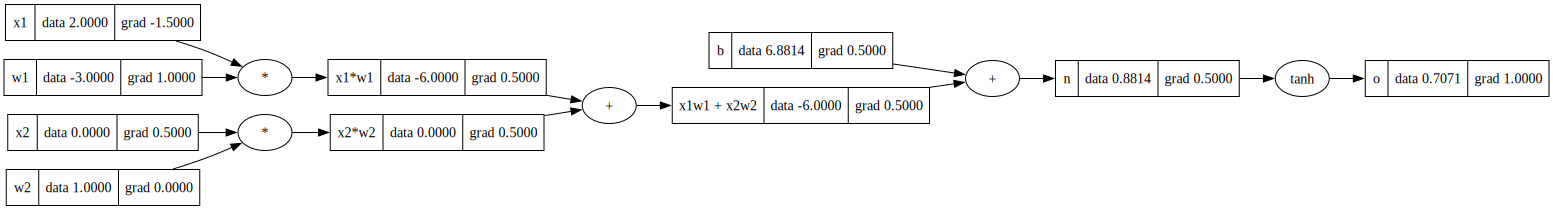

In [103]:
draw_dot(o)

In [109]:
# Change o to tanh's expression

# inputs
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

# weights
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label= 'w2')

b = Value(6.8813735870195432, label='b')

x1w1 = x1*w1 
x1w1.label = 'x1*w1'

x2w2 = x2*w2
x2w2.label = 'x2*w2'

x1w1x2w2 = x1w1 + x2w2
x1w1x2w2.label = 'x1w1 + x2w2'

n = x1w1x2w2 + b
n.label = 'n'

e = (2*n).exp()

o = (e - 1) / (e + 1) 

o.backward()


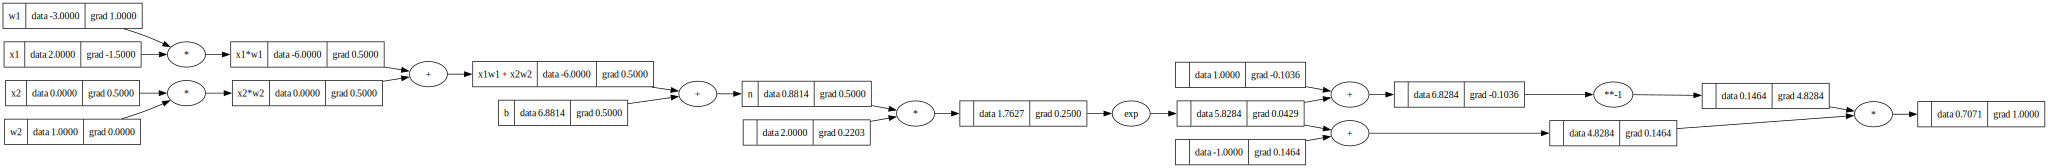

In [111]:
draw_dot(o)

In [112]:
import random

In [ ]:
class Neuron:

    def __init__(self, nin):
        self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]
        self.b = Value(random.uniform(-1,1))

    def __call__(self, x):
        # w . x + b
        act = sum((wi*xi for wi, xi in zip(self.w, x)), self.b) 
        out = act.tanh()
        return out
    
    def parameters(self):
        return self.w + [self.b]
    
class Layer:

    def __init__(self, nin, nout):
        self.neurons = [Neuron(nin) for _ in range(nout)]

    def __call__(self, x):
        out = [n(x) for n in self.neurons]
        # --> list of size n_out: [---#weights_neuron---]
        return out[0] if len(out) == 1 else out
    
    def parameters(self):
        # params = []
        # for neuron in self.neurons:
        #     params.extend(neuron.parameters())
        return [p for neuron in self.neurons for p in neuron.parameters()]
        

class MLP:

    def __init__(self, n_in, n_out):
        # n_out: list of output size for each layer
        size = [n_in] + n_out
        # --> [nin, nout_1, nout_2, ..., nout_n]

        self.layers = [Layer(size[i], size[i+1]) for i in range(len(n_out))]
        # ---> [(nin,nout_1),  <-- layer 0
        #       (nout_1, nout_2),
        #        ...........
        #       (nout_n-1, nout_n)]    <-- layer nout_n-1       

    def __call__(self, x):
        for layer in self.layers:
            x = layer(x) # recursively compute x output and feed to the next iteration
        return x       

    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]

Value(data=0.5196739905538115)

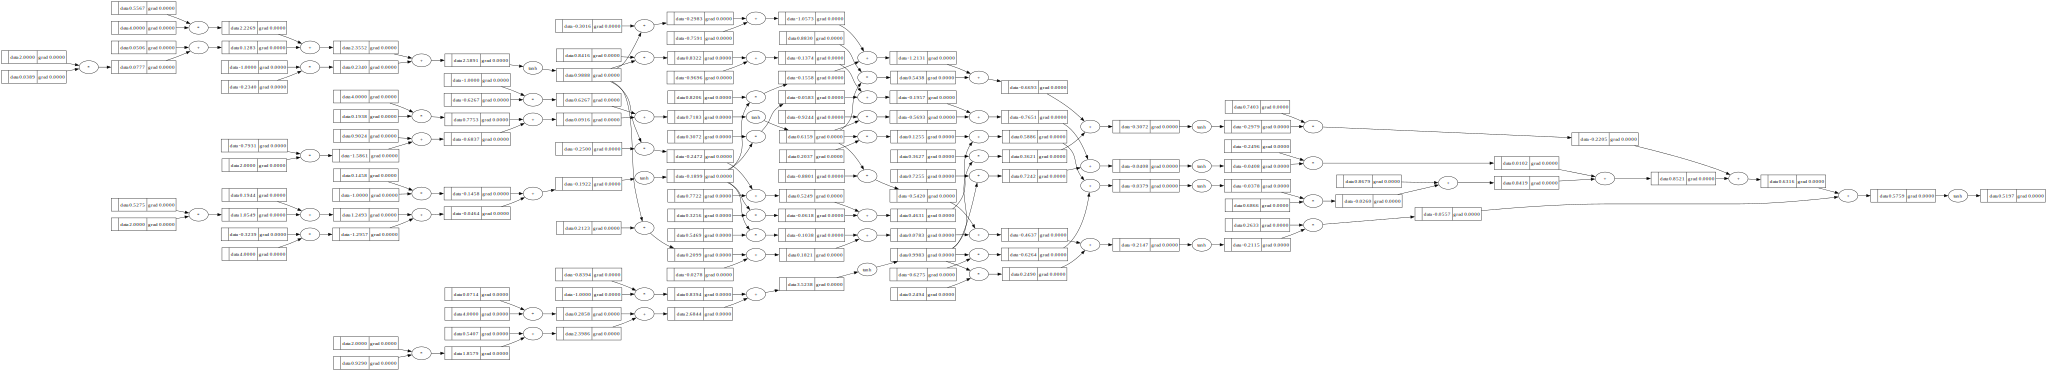

In [132]:
draw_dot(n(x))

In [137]:
# 1 batch of data with 4 datapoints
xs = [
    [2.0, 3.0, -1.0],
    [3.0, -1.0, 0.5],
    [0.5, 1.0, 1.0],
    [1.0, 1.0, -1.0],
]

ys = [1.0, -1.0, -1.0, 1.0] # target

# n(x): output for 1 single datapoint
y_pred = [n(x) for x in xs]
y_pred

[Value(data=0.6430080815714576),
 Value(data=0.7672734203240864),
 Value(data=0.7903866690170822),
 Value(data=0.8349965083948908)]

In [143]:
loss = sum((ypred - y)**2 for y, ypred in zip(ys, y_pred))

In [144]:
loss

Value(data=6.483409148843247)

In [145]:
loss.backward()

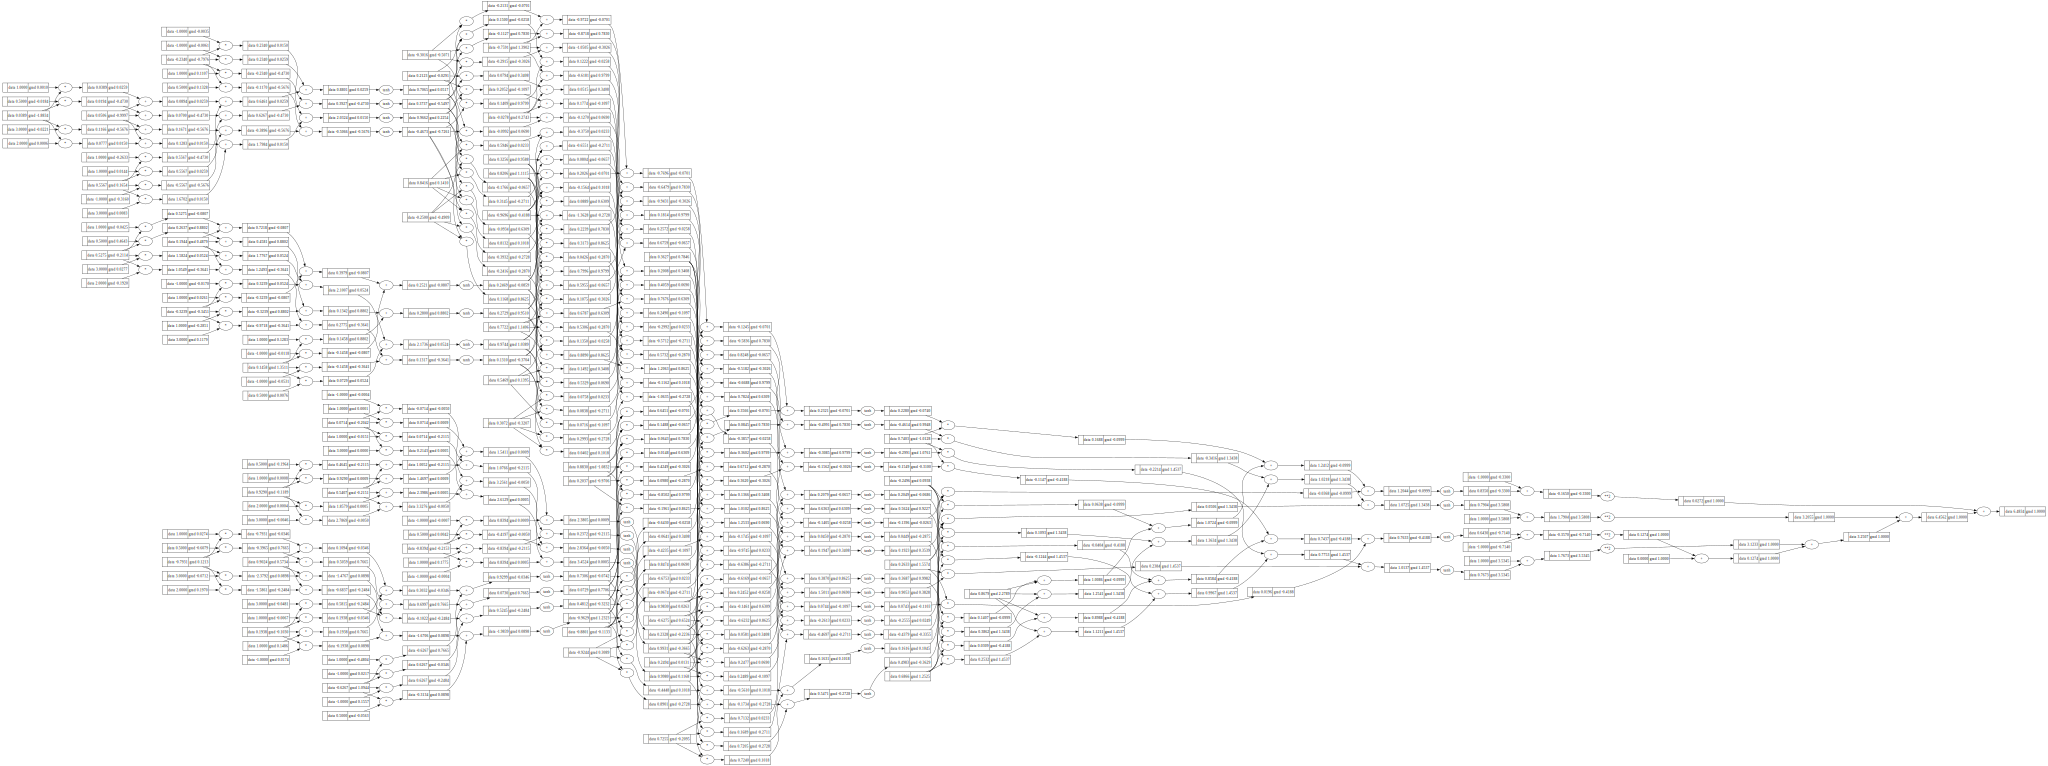

In [146]:
draw_dot(loss)